In [2]:
!pip install seaborn
!pip install timm

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [3]:
import numpy as np
import pandas as pd 
import os
from jarviscloud import jarviscloud
from torch import nn
import torch
from tqdm import tqdm
import albumentations as A
import cv2
import timm
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
sys.path.append("../python/")

from hyperparams import Hyperparams
import model_classes as mc


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder_name, latent_dim):
        super(AutoEncoder, self).__init__()
        
        # encoder
        self.encoder = timm.create_model(encoder_name,in_chans=1, pretrained=True,)
        num_embeddings  = self.encoder.classifier.in_features
        modules = list(self.encoder.children())[:-1]
        self.encoder = nn.Sequential(*modules)
        
        self.latent_layer = nn.Linear(num_embeddings, latent_dim)
        
        # decoder
        self.decoder_input = nn.Linear(latent_dim, num_embeddings)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(num_embeddings, 512, kernel_size=2, stride=2),  # 1x1 to 2x2
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 2x2 to 4x4
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 4x4 to 8x8
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 8x8 to 16x16
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),  # 8x8 to 16x16
            nn.ReLU(),

            nn.Conv2d(1,1, kernel_size=5, stride=1, padding =0),
        )

        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.latent_layer(x)
        x = self.decoder_input(x)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.decoder(x)
        return x

    def encode(self,x): #expected shape : (BS, C, H, W)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.latent_layer(x)
        return x

    def decode(self,x): #expected shape : (BS, latent_space)
        x = self.decoder_input(x)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.decoder(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoEncoder(encoder_name = 'efficientnet_b0', latent_dim = 2)
model.eval()
state_dict = torch.load('../running_models/fold_1/me_0.400_ep_10_en_efficientnet_b0_lr_0.0005_si_28.pt', map_location = device)
model.to(device)
model.load_state_dict(state_dict, strict = True)

<All keys matched successfully>

In [7]:
from stratified_kfold_loaders import *
from torch.cuda.amp import autocast

#Mock metadata
metadata = pd.read_csv('../data/metadatas/metadata.csv')
all_images = np.load('../data/images_labels/images.npy')

train_loaders, valid_loaders, splits  = kfold_loaders(
        metadata = metadata, 
        all_images = all_images,
        normalise_transform = Hyperparams.normalise_transform,
        batch_size_train = Hyperparams.batch_size_train, 
        batch_size_valid = Hyperparams.batch_size_valid,
        num_splits=Hyperparams.num_splits, 
        random_state=Hyperparams.random_state)

In [8]:
all_images = np.load('../data/images_labels/images.npy')
all_labels = np.load('../data/images_labels/labels.npy')

In [9]:
valid_indices = splits[0][1]

In [10]:
images = torch.tensor(all_images[valid_indices] !=0 ).unsqueeze(1).to(device).float()
labels = all_labels[valid_indices]

In [11]:
with torch.no_grad():
    outputs = model.encode(images)
outputs = outputs.cpu()

In [15]:
x_range = np.linspace(-50, 10, 10)
y_range = np.linspace(-25, 10, 10)

# Create a grid of values
x_values, y_values = np.meshgrid(x_range, y_range)
coords = np.column_stack((x_values.ravel(), y_values.ravel()))

In [16]:
new_latent = torch.tensor(coords).float().to(device)
with torch.no_grad():
    new_image = model.decode(new_latent)

new_image = new_image.cpu()

# plt.imshow((new_image.cpu().squeeze(0,1)) >0.5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 100x1280)

NameError: name 'new_image' is not defined

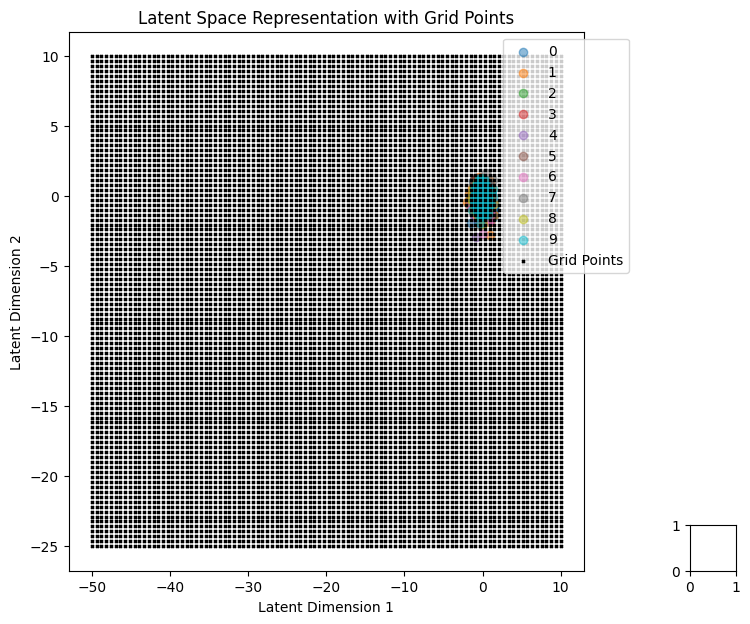

In [14]:
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.05])

# Scatter plot
ax0 = plt.subplot(gs[0])
for i in range(10):
    mask = (labels == i)
    ax0.scatter(outputs[mask, 0], outputs[mask, 1], label=str(i), alpha=0.5)
ax0.scatter(coords[:, 0], coords[:, 1], s=4, c='black', label='Grid Points',marker = 'x')
ax0.set_xlabel('Latent Dimension 1')
ax0.set_ylabel('Latent Dimension 2')
ax0.legend(bbox_to_anchor=(1.10, 1), loc='upper right')
ax0.set_title('Latent Space Representation with Grid Points')

# Image grid
gs1 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[1])
for i in range(100):
    for j in range(100):
        ax = plt.subplot(gs1[9 - i, j])
        img = new_image[i*10 + j].squeeze(0)
        ax.imshow(img > 0.4, cmap='gray')
        ax.axis('off')

fig.suptitle('Model output of Grid Points Vector Representation', x=0.78, y=0.93, fontsize=13)
fig.suptitle(f'{Hyperparams.encoder_name} encoder', fontsize=16, y=1.00)
fig.text(0.78, 0.92, 'Model output of Grid Points Vector Representation', fontsize=13, ha='center')

plt.tight_layout()
plt.savefig(f"../plots/{Hyperparams.encoder_name}.png")
plt.show()


In [21]:
'eca_nfnet_l0'

'eca_nfnet_l0'